In [665]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque

In [666]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
    
    
class RandomAgent:
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
    def compute_action(self, state):
        return np.random.uniform(-1, 1, size=(self.action_size, ))

## Heuristic policy

In [667]:
def create_env_agent(agent):
    env = gym.make('Pendulum-v1')
    env = NormalizedEnv(env)
    agent = agent(env)
    return env, agent

In [668]:
def run_episode(env, agent, max_it = 200):
    state = env.reset()[0]
    it = 0
    rewards = []
    done = False
    while not done:
        action = agent.compute_action(state)
        state, reward, _ , trunc, _ = env.step(action)
        rewards.append(reward)
        done = trunc
        if done or it == max_it - 1:
            done = True
        it += 1
    return rewards

In [669]:
env, random_agent = create_env_agent(RandomAgent)

reward = np.sum(run_episode(env, random_agent))
reward

-1078.721776627273

In [670]:
def run_episodes(env, agent, num_episodes=10):
    rewards = []
    cumulative_reward = []
    for i in range(num_episodes):
        rewards.append(np.sum(run_episode(env, agent)))
        cumulative_reward.append(np.mean(rewards))
        
    #plot the average cumulative reward
    plt.plot(cumulative_reward)
    return np.mean(cumulative_reward)

-1181.6697360494861

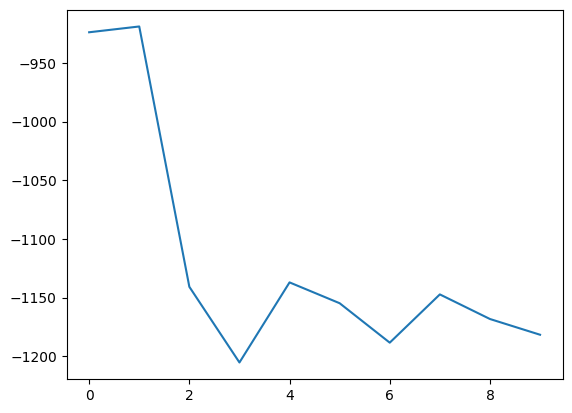

In [671]:
cumulative_reward = run_episodes(env, random_agent)
cumulative_reward

In [672]:
class HeuristicPendulumAgent:
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
    def compute_action(self, state, torque=1.):
        #if y coordinates has aboslute value higher than 0.5, then apply force to move it back to 0
        if np.abs(state[1]) < 0.5:
            # create an array of size (self.action_size, ) filled by torque * np.sign(state[0][2])
            value = torque * np.sign(state[2])
            array = np.full(self.action_size, value)
            return array 
        else:
            value = -torque * np.sign(state[2])
            array = np.full(self.action_size, value)
            return array

In [673]:
def run_episode_heuristic(env, agent, max_it = 200, torque=1.):
    state = env.reset()[0]
    it = 0
    rewards = []
    done = False
    while not done:
        action = agent.compute_action(state, torque=torque)
        state, reward, _ , trunc, _ = env.step(action)
        rewards.append(reward)
        done = trunc
        if done or it == max_it - 1:
            done = True
        it += 1
    return rewards

In [674]:
def run_episodes_heuristic(env, agent, num_episodes=10, torque=1.):
    rewards = []
    cumulative_reward = []
    for i in range(num_episodes):
        rewards.append(np.sum(run_episode_heuristic(env, agent, torque=torque)))
        cumulative_reward.append(np.mean(rewards))
        
    return cumulative_reward

In [675]:
env, heuristic_agent = create_env_agent(HeuristicPendulumAgent)
#make i between -1 and 1 with step 0.2
tab = []
for i in range(1, 11):
    torque = i/10
    cumulative_reward = run_episodes_heuristic(env, heuristic_agent, torque=torque)
    tab.append([torque, cumulative_reward])

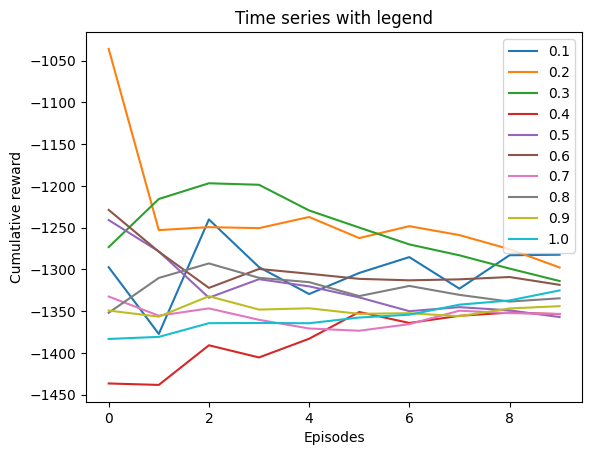

In [676]:
for i in range(len(tab)):
    data = tab[i]
    label = data[0]
    sns.lineplot(x=range(len(data[1])), y=data[1], label=label)

# Adding title and labels
plt.title("Time series with legend")
plt.xlabel("Episodes")
plt.ylabel("Cumulative reward")

# Showing the plot
plt.show()

We clearly obtain a high better fit than with the RandomAgent. We observe that more the torque is near 1 more the model fit well. 

## Q function of the heuristic policy

In [677]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
        
    def add_transition(self, state, action, reward, next_state, trunc):
        self.buffer.append([state, action, reward, next_state, trunc])
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
        
    def size(self):
        return len(self.buffer)

In [678]:
class QNetwork(nn.Module):
    def __init__(self, state_size = 3, action_size = 1, hidden_size=32):
        super(QNetwork, self).__init__()
        self.lin1 = nn.Linear(state_size + action_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)        

In [720]:
def one_step_TD_learning_QN(Q, batch, agent, optimizer, gamma=0.99):
    state_batch = torch.cat([item[0] for item in batch])
    action_batch = torch.cat([item[1] for item in batch])
    reward_batch = torch.cat([item[2] for item in batch])
    next_state_batch = torch.cat([item[3] for item in batch])

    outputs = Q(state_batch, action_batch.unsqueeze(1))

    next_action_batch = torch.cat([torch.tensor(agent.compute_action(state.numpy()), dtype=torch.float32) for state in next_state_batch])

    with torch.no_grad():
        #Take max over all actions
        target_batch = Q(next_state_batch, next_action_batch.unsqueeze(1)).max(1)[0]
        
    target_batch = reward_batch + gamma * target_batch

    loss = F.mse_loss(outputs, target_batch.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [725]:

def train_DQN(agent, buffer, q_network, optimizer, batch_size, num_episodes, gamma=0.99):
    loss_per_episode = []
    for i in range(num_episodes):
        
        state = env.reset()[0]
        #Transform state into tensor
        state = torch.tensor(state).unsqueeze(0)
        done = False
        losses = []
        while not done:
            action = agent.compute_action(state.numpy().flatten())
            
            next_state, reward, _, trunc, _ = env.step(action)
            
            action = torch.tensor(action, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            buffer.add_transition(state, action, reward, next_state, trunc)
            state = next_state
            done = trunc
            
            if buffer.size() >= batch_size:  
                batch = buffer.sample(batch_size)
                loss = one_step_TD_learning_QN(q_network, batch, agent, optimizer, gamma)
                losses.append(loss.item())
        loss_per_episode.append(np.mean(losses))
    return loss_per_episode

In [726]:
BUFFER_SIZE = 1000
N_EPISODES = 1000
GAMMA = 0.99
LEARNING_RATE = 1e-4
BATCH_SIZE = 128

heuristic_agent_DQN = HeuristicPendulumAgent(env)
buffer_DQN = ReplayBuffer(BUFFER_SIZE)
q_network_DQN = QNetwork()
optimizer_DQN = optim.SGD(q_network_DQN.parameters(), lr=LEARNING_RATE)

loss_per_episode_DQN = train_DQN(heuristic_agent_DQN, buffer_DQN, q_network_DQN, optimizer_DQN, BATCH_SIZE, N_EPISODES, GAMMA)

Text(0, 0.5, 'Loss')

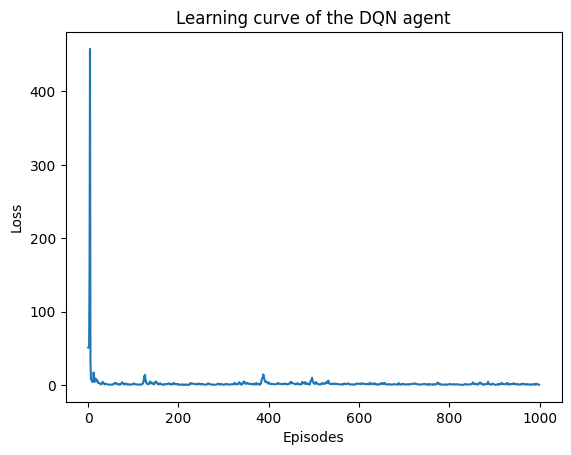

In [728]:
sns.lineplot(x=range(len(loss_per_episode_DQN)), y=loss_per_episode_DQN)
plt.title("Learning curve of the DQN agent")
plt.xlabel("Episodes")
plt.ylabel("Loss")

In [882]:
def plot_heatmap(q_network):

    pairs = [[-2, -5], [-1, 3], [0, 5], [1, 3], [2, -5]]

    def get_q_values(q_network, angles, action, velocity):
        num_angles = len(angles)
        q_values = np.zeros(num_angles)

        for i, angle in enumerate(angles):
            state = torch.tensor([np.cos(angle), np.sin(angle), velocity], dtype=torch.float32).unsqueeze(0)
            action_tensor = torch.tensor([action], dtype=torch.float32)
            q_values[i] = q_network(state, action_tensor.unsqueeze(1))
        return q_values

    # Assuming you have a QNetwork class defined that can predict Q-values for a given state

    # Define the angles and actions
    num_angles = 100
    angles = np.linspace(-np.pi, np.pi, num_angles)

    # Create an instance of the Q-network
    for pair in pairs:
        action, velocity = pair
        pre_trained_q_network = QNetwork()

        # Get the Q-values before training
        q_values_before_training = get_q_values(pre_trained_q_network, angles, action, velocity)

        # Plot the polar heatmap before training
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='polar')
        cax = ax.scatter(angles, np.ones_like(angles), c=q_values_before_training, cmap='hot')
        ax.set_yticklabels([])
        plt.colorbar(cax)
        plt.title("Polar Heatmap of Q-Values (Before Training)\nVelocity: {}  Action: {}".format(velocity, action))
        plt.show()

        # Perform the training of the Q-network here

        # Get the Q-values after training
        q_values_after_training = get_q_values(q_network, angles, action, velocity)

        # Plot the polar heatmap after training
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='polar')
        cax = ax.scatter(angles, np.ones_like(angles), c=q_values_after_training, cmap='hot')
        ax.set_yticklabels([])
        plt.colorbar(cax)
        plt.title("Polar Heatmap of Q-Values (After Training)\nVelocity: {}  Action: {}".format(velocity, action))
        plt.show()

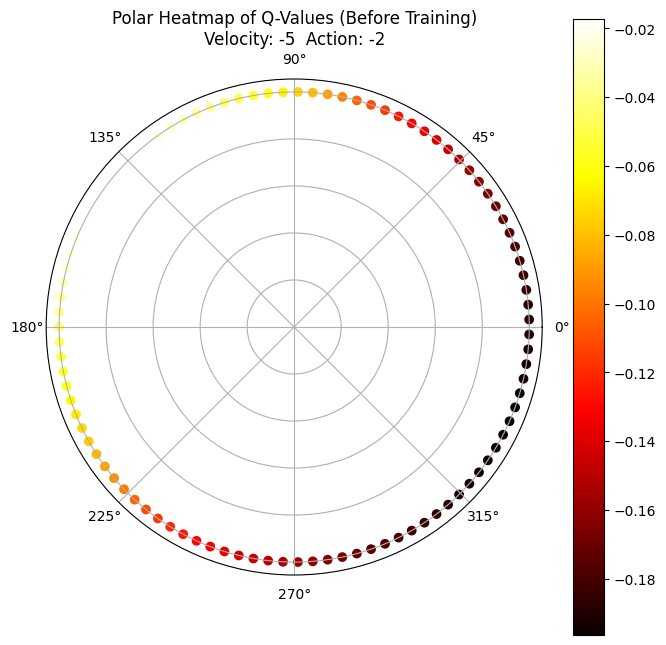

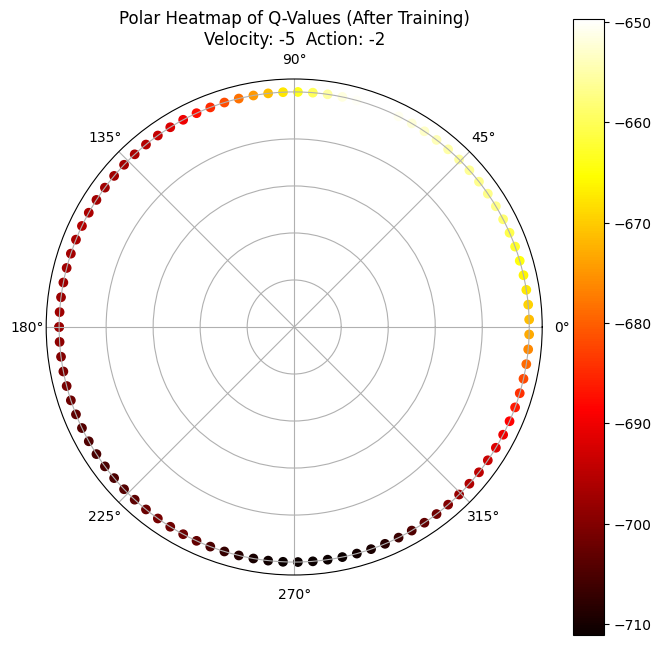

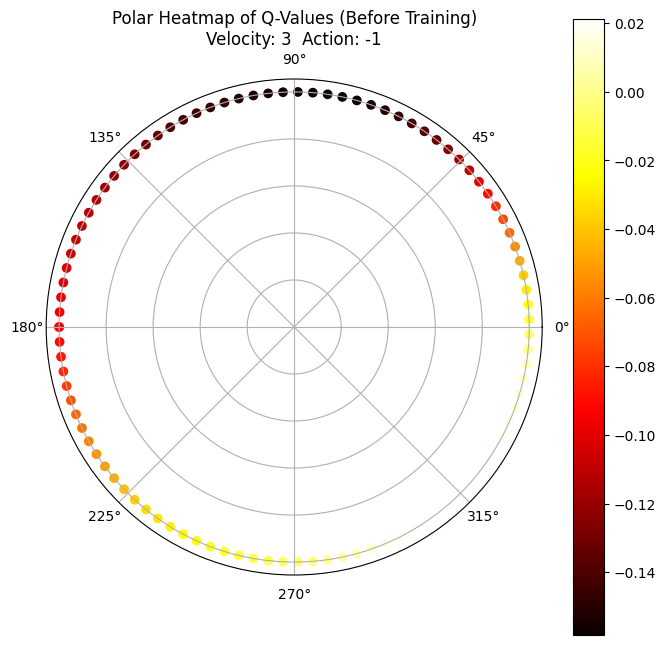

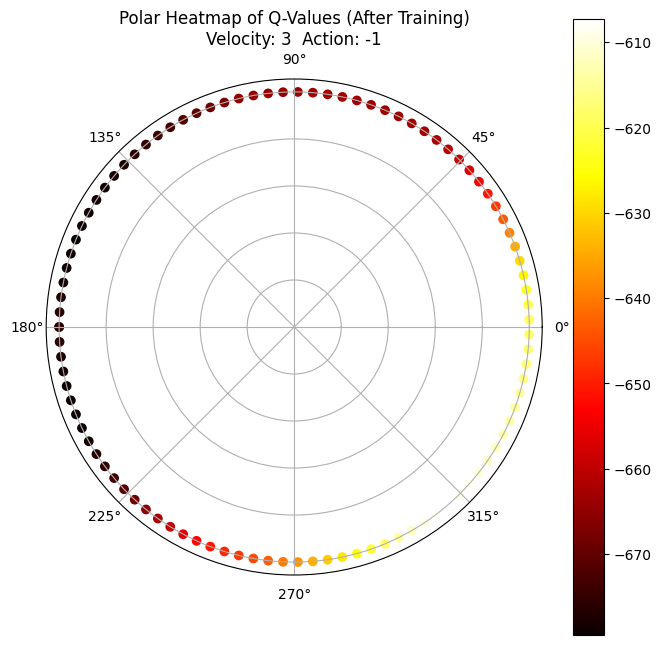

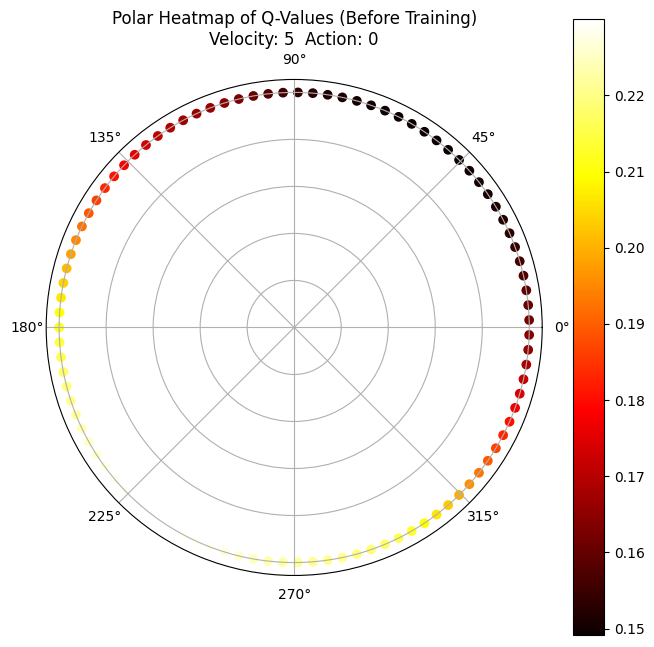

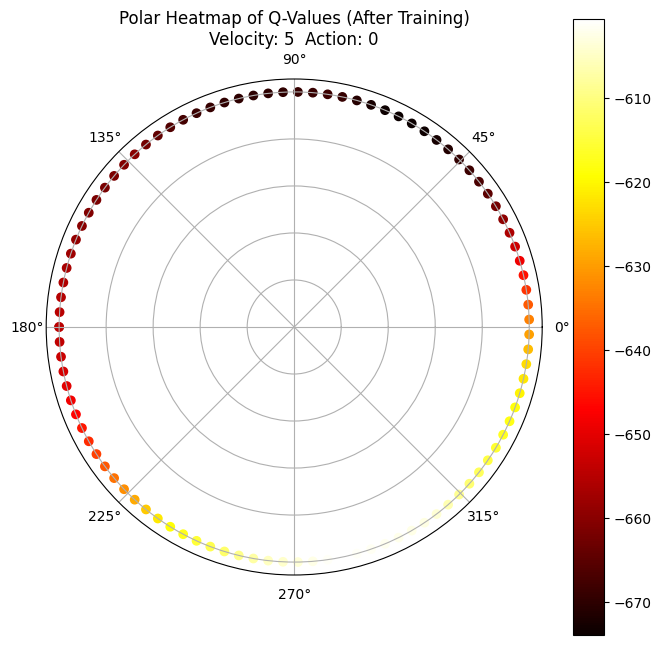

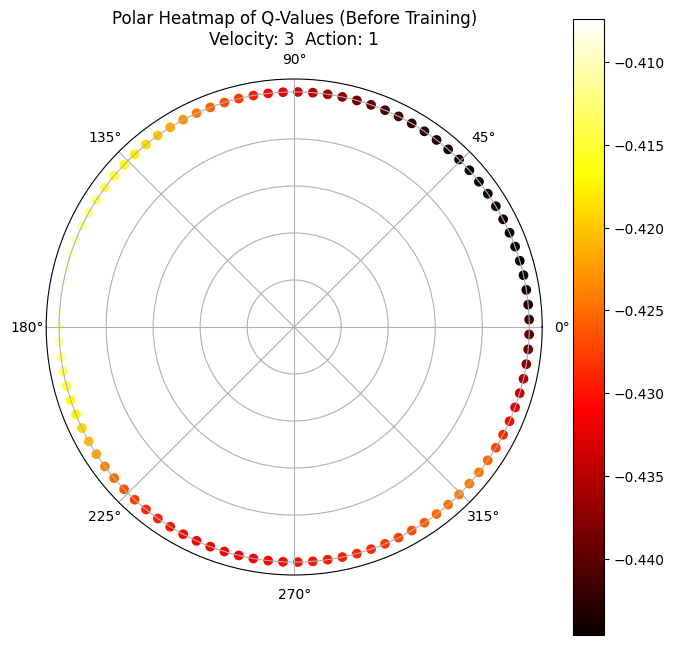

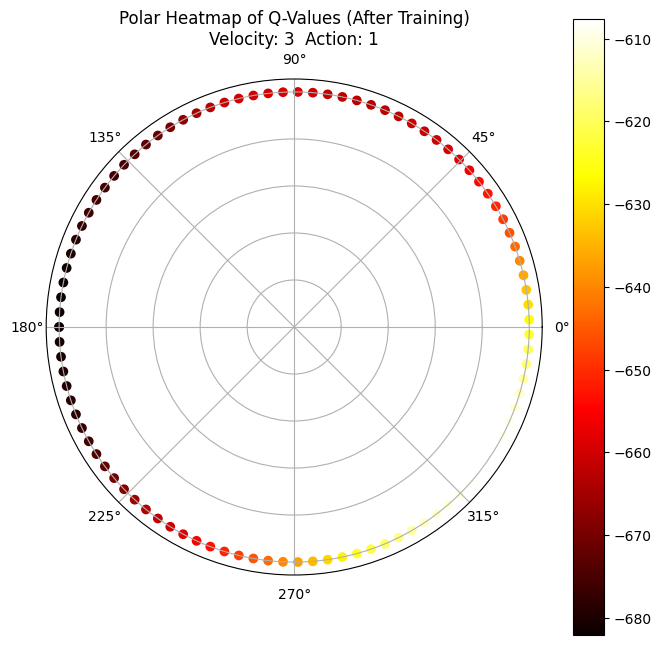

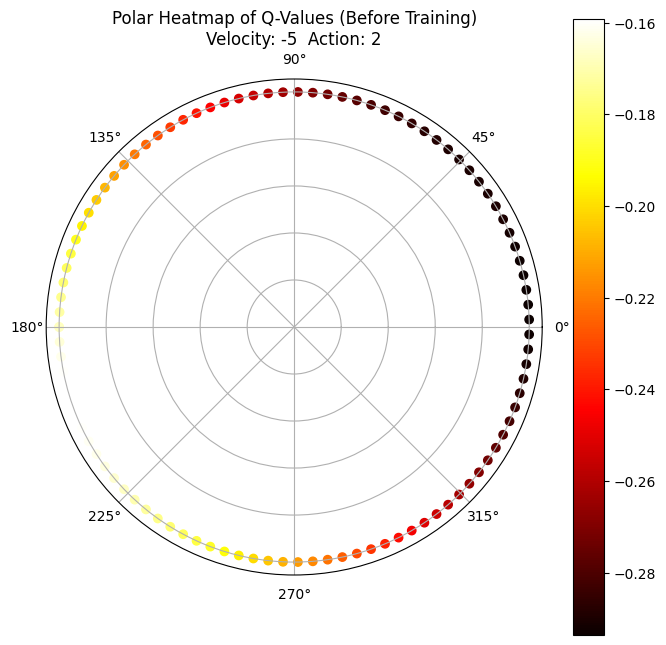

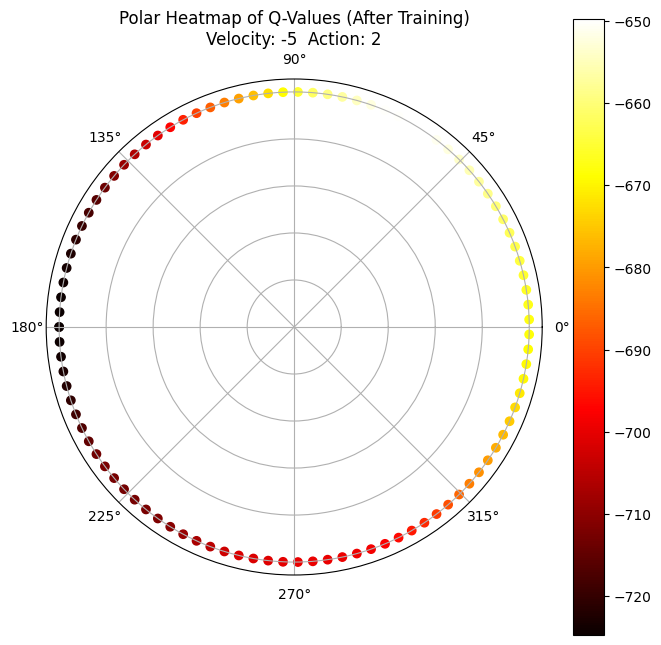

In [883]:
plot_heatmap(q_network_DQN)

## Minimal implementation of DDPG

In [844]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size = 3, action_size = 1, hidden_size=32):
        super(PolicyNetwork, self).__init__()
        self.lin1 = nn.Linear(state_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, action_size)
    
    def forward(self, state):
        x = F.relu(self.lin1(state))
        x = F.relu(self.lin2(x))
        x = torch.tanh(self.lin3(x))
        return x

In [845]:
class GaussianActionNoise:
    def __init__(self, std_dev):
        self.std_dev = std_dev

    def get_noisy_action(self, action):
        noise = np.random.normal(scale=self.std_dev)
        noisy_action = action.detach() + noise
        noisy_action = np.clip(noisy_action, -1, 1)
        return noisy_action

In [846]:
class DDPGAgent:
    def __init__(self, p_network, action_noise):
        self.p_network = p_network
        self.action_noise = action_noise

    def compute_action(self, state, deterministic=True):
        action = self.p_network(state)

        if not deterministic:
            noisy_action = self.action_noise.get_noisy_action(action)
            return noisy_action
        else:
            return action


In [847]:
def TD_learning_DDPQ(Q, P, batch, agent, q_optimizer, p_optimizer, gamma=0.99, deterministic=True):
    state_batch = torch.cat([item[0] for item in batch])
    action_batch = torch.cat([item[1] for item in batch])
    reward_batch = torch.cat([item[2].unsqueeze(0) for item in batch])
    next_state_batch = torch.cat([item[3] for item in batch])
    done_batch = torch.cat([item[4].unsqueeze(0) for item in batch])
            
    outputs = Q(state_batch, action_batch.unsqueeze(1))

    with torch.no_grad():
        next_action_batch = torch.tensor(agent.compute_action(next_state_batch), dtype=torch.float32)
        target_batch = reward_batch + gamma * Q(next_state_batch, next_action_batch) * (1 - done_batch)
        
    q_loss = F.mse_loss(outputs, target_batch)
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()
        
    p_loss = -Q(state_batch, P(state_batch)).mean()
    p_optimizer.zero_grad()
    p_loss.backward()
    p_optimizer.step()
        
    return q_loss, p_loss


In [848]:
def train_DDPG(q_network, p_network, agent, buffer, q_optimizer, p_optimizer, deterministic, gamma, num_episodes, batch_size):
    q_loss_per_step = []
    p_loss_per_step = []
    cumulative_reward_per_episode = []

    for i in range(num_episodes):
        state = env.reset()[0]
        state = torch.tensor(state).unsqueeze(0)
        done = False
        rewards = 0
        
        while not done:
            action = agent.compute_action(state, deterministic)
            action = action.detach().numpy().flatten()
            
            next_state, reward, _, trunc, _ = env.step(action)
            
            action = torch.tensor(action, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            trunc = torch.tensor(trunc, dtype=torch.float32).unsqueeze(0)
            
            buffer.add_transition(state, action, reward, next_state, trunc)
            state = next_state
            done = trunc
            rewards += reward.item()
        
            if buffer.size() >= batch_size:  
                batch = buffer.sample(batch_size)
                q_loss, p_loss = TD_learning_DDPQ(q_network, p_network, batch, agent, q_optimizer, p_optimizer, gamma, deterministic)
                q_loss_per_step.append(q_loss.item())
                p_loss_per_step.append(p_loss.item())
        
        cumulative_reward_per_episode.append(rewards / num_episodes)
    return q_loss_per_step, p_loss_per_step, cumulative_reward_per_episode

In [858]:
BUFFER_SIZE = 10000
N_EPISODES = 1000
GAMMA = 0.99
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
STD_DEV = 0.3
DETERMINISTIC = True

q_network_DDPG = QNetwork()
p_network_DDPG = PolicyNetwork()
agent = DDPGAgent(p_network_DDPG, GaussianActionNoise(STD_DEV))
buffer = ReplayBuffer(BUFFER_SIZE)

q_optimizer = optim.SGD(q_network_DDPG.parameters(), lr=LEARNING_RATE)
p_optimizer = optim.SGD(p_network_DDPG.parameters(), lr=LEARNING_RATE)

q_loss_per_step, p_loss_per_step, cumulative_reward_per_episode = train_DDPG(q_network_DDPG, p_network_DDPG, agent, buffer, q_optimizer, p_optimizer, DETERMINISTIC, GAMMA, N_EPISODES, BATCH_SIZE)

/var/folders/hv/67_537bx1cb2f2v1x8cw8k0m0000gn/T/ipykernel_50814/654915415.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_action_batch = torch.tensor(agent.compute_action(next_state_batch), dtype=torch.float32)


<Axes: >

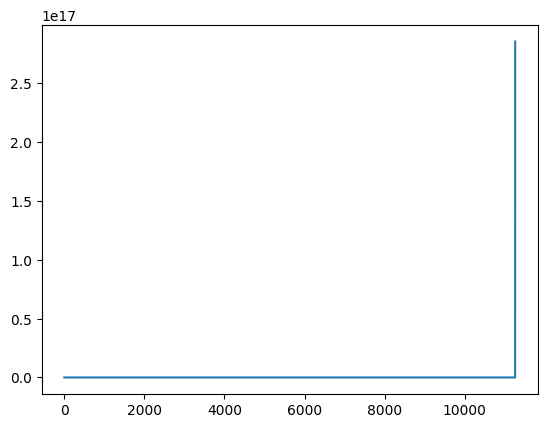

In [859]:
sns.lineplot(x=range(len(q_loss_per_step)), y=q_loss_per_step)

<Axes: >

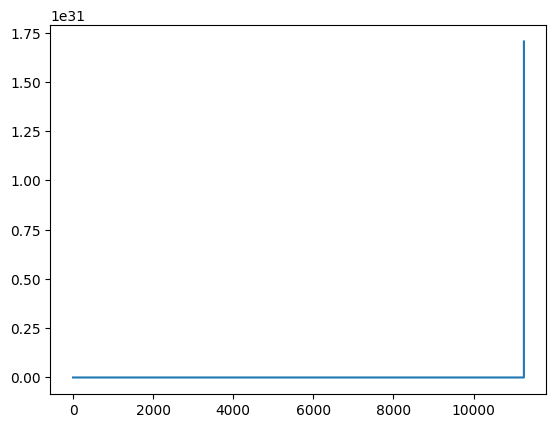

In [860]:
sns.lineplot(x=range(len(p_loss_per_step)), y=p_loss_per_step)

<Axes: >

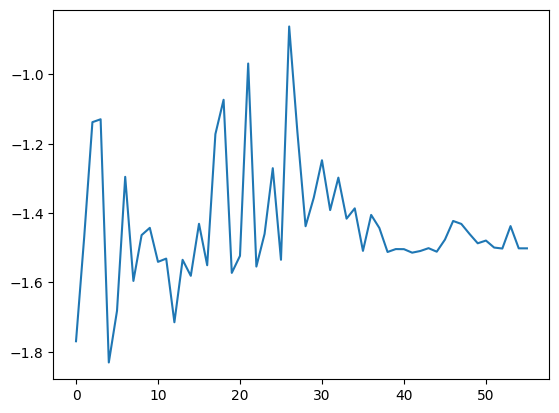

In [861]:
sns.lineplot(x=range(len(cumulative_reward_per_episode)), y=cumulative_reward_per_episode)

In [881]:
def test_policy(agent, env, n_episodes=100, deterministic=True):
    cumulative_rewards = []
    
    for _ in range(n_episodes):
        state = env.reset()[0]
        state = torch.tensor(state).unsqueeze(0)
        done = False
        cumulative_reward = 0
        
        while not done:
            action = agent.compute_action(state, deterministic)
            action = action.detach().numpy().flatten()
            
            next_state, reward, _, trunc, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            
            cumulative_reward += reward
            state = next_state
            done = trunc
        
        cumulative_rewards.append(cumulative_reward)
    
    average_reward = sum(cumulative_rewards) / n_episodes
    return average_reward

# Test the policy
average_reward = test_policy(agent, env, n_episodes=100, deterministic=DETERMINISTIC)
print("Average cumulative reward:", average_reward)

Average cumulative reward: -1582.9092110086376


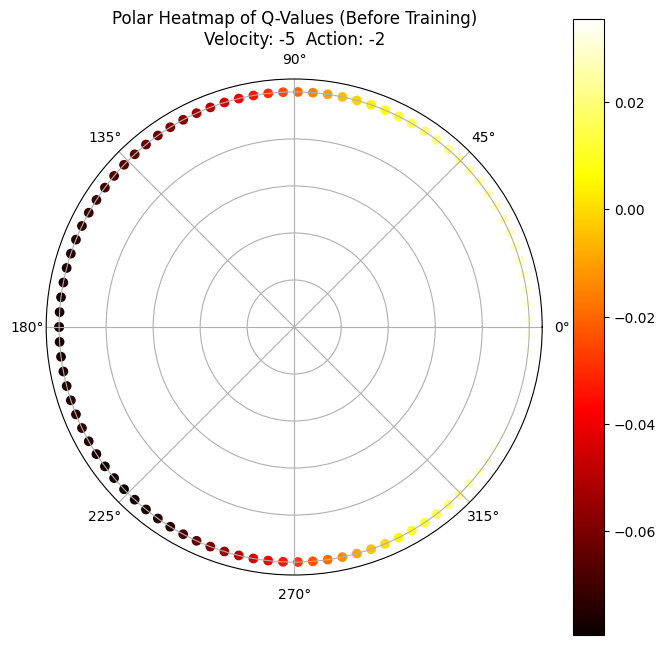

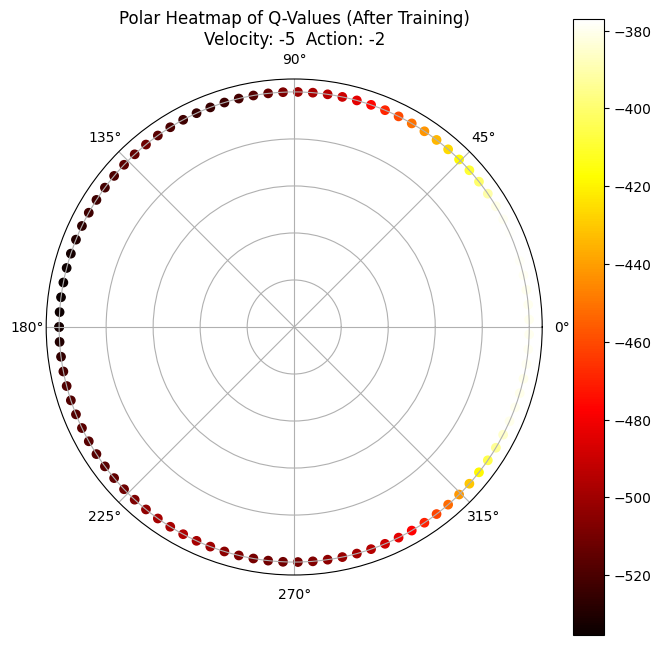

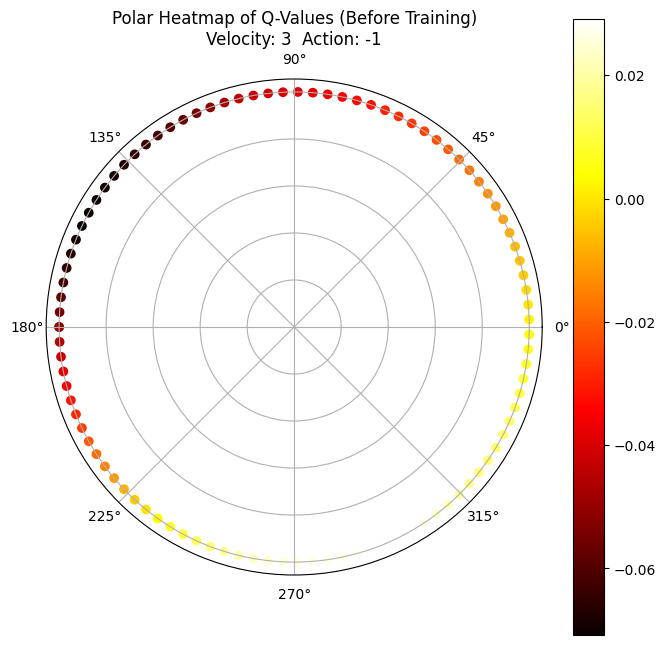

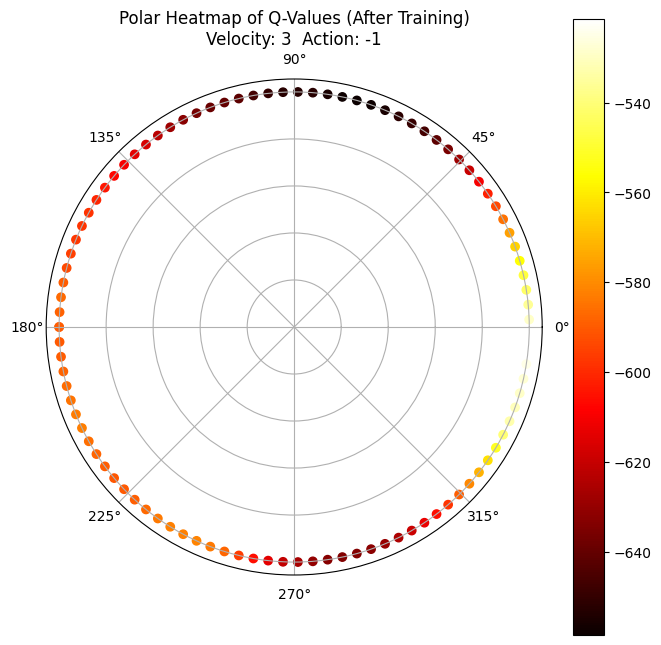

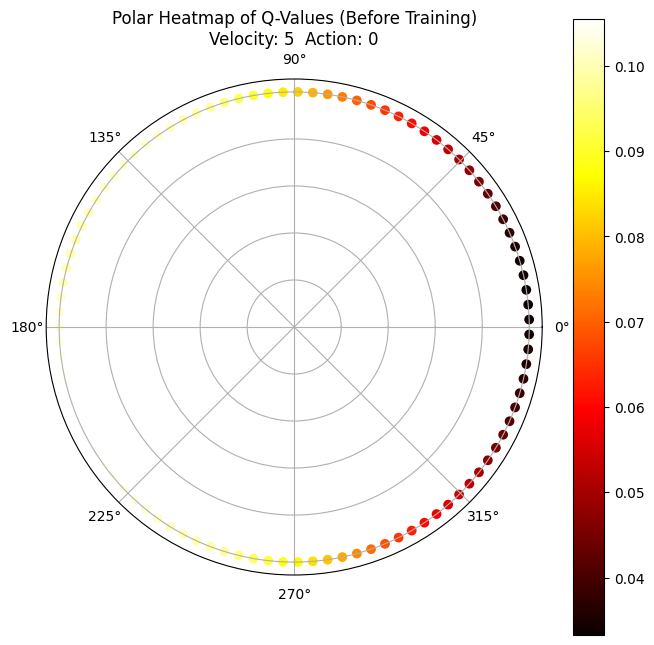

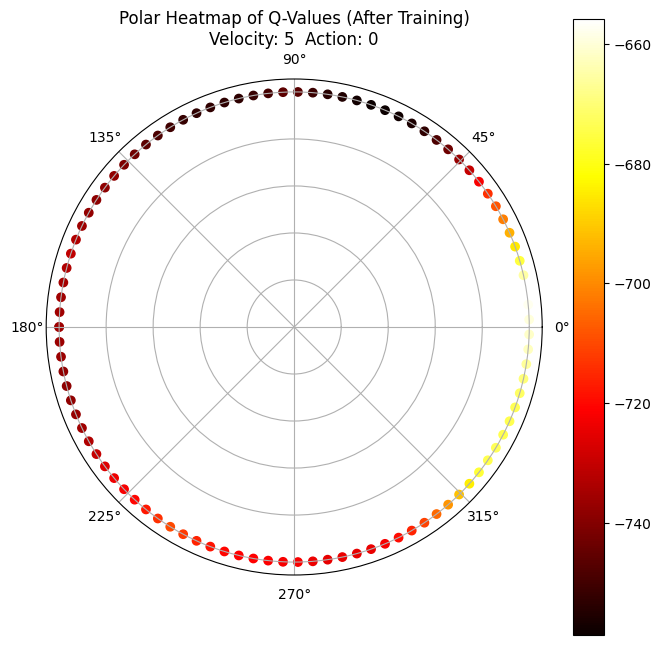

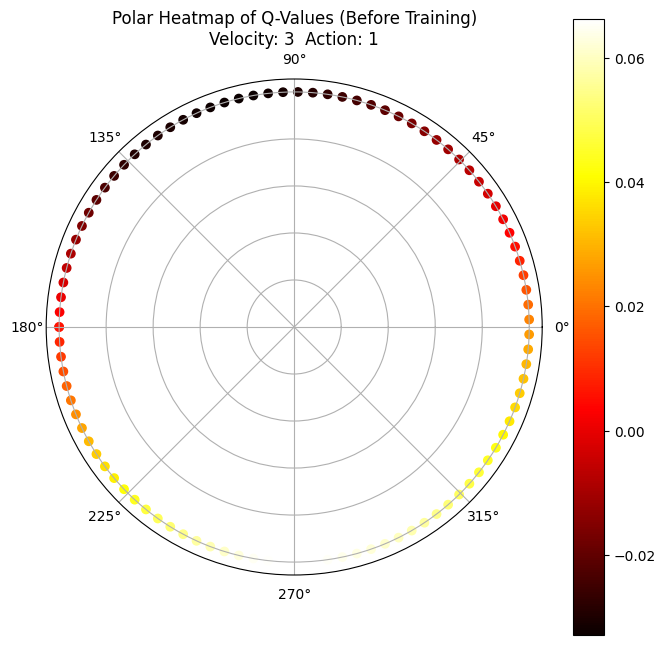

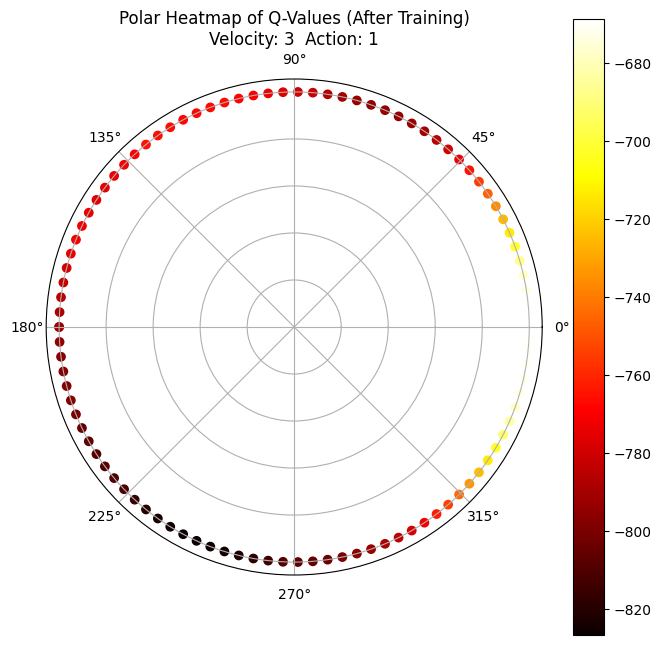

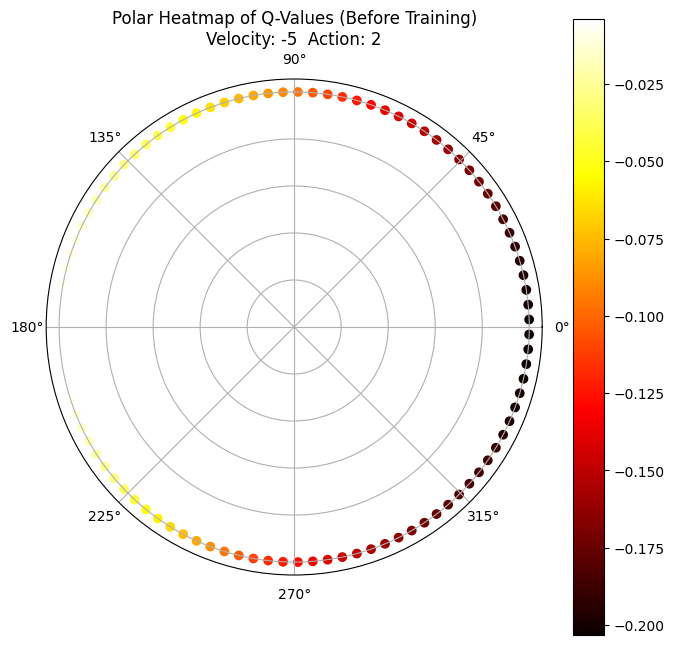

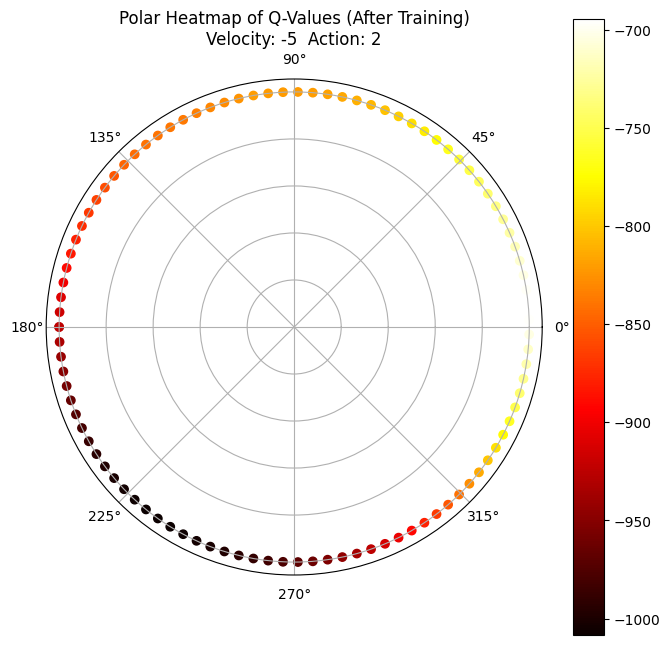

In [884]:
plot_heatmap(q_network_DDPG)

# Target networks

In [876]:
def update_target_params(Q, P, Q_target, P_target, tau):
    for target_param, param in zip(Q_target.parameters(), Q.parameters()):
        target_param.data.copy_((1 - tau) * target_param.data + tau * param.data)

    for target_param, param in zip(P_target.parameters(), P.parameters()):
        target_param.data.copy_((1 - tau) * target_param.data + tau * param.data)


In [877]:
def TD_learning_DDPQ_TAU(Q, P,Q_target, P_target, batch, agent, q_optimizer, p_optimizer, gamma=0.99, deterministic=True, tau = 0.01):
    state_batch = torch.cat([item[0] for item in batch])
    action_batch = torch.cat([item[1] for item in batch])
    reward_batch = torch.cat([item[2].unsqueeze(0) for item in batch])
    next_state_batch = torch.cat([item[3] for item in batch])
    done_batch = torch.cat([item[4].unsqueeze(0) for item in batch])
            
    outputs = Q(state_batch, action_batch.unsqueeze(1))
    next_action_batch = torch.tensor([agent.compute_action(state).detach().numpy().flatten() for state in next_state_batch], dtype=torch.float32)

    with torch.no_grad():
        next_action_batch = torch.tensor(agent.compute_action(next_state_batch), dtype=torch.float32).clone().detach()
        target_batch = reward_batch + gamma * Q(next_state_batch, next_action_batch) * (1 - done_batch)
        
    target_batch = reward_batch + gamma * target_batch
    
    q_loss = F.mse_loss(outputs, target_batch)
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()
        
    p_loss = -Q_target(state_batch, P_target(state_batch)).mean()
    p_optimizer.zero_grad()
    p_loss.backward()
    p_optimizer.step()
    
    update_target_params(Q,P,Q_target, P_target, tau)    
    return q_loss, p_loss


In [878]:
def train_DDPG_TAU(q_network, p_network, q_network_target, p_network_target, agent, buffer, q_optimizer, p_optimizer, tau, deterministic, gamma, num_episodes, batch_size):
    q_loss_per_step = []
    p_loss_per_step = []
    cumulative_reward_per_episode = []

    for i in range(num_episodes):
        state = env.reset()[0]
        state = torch.tensor(state).unsqueeze(0)
        done = False
        rewards = 0
        
        while not done:
            action = agent.compute_action(state, deterministic)
            action = action.detach().numpy().flatten()
            
            next_state, reward, _, trunc, _ = env.step(action)
            
            action = torch.tensor(action, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            trunc = torch.tensor(trunc, dtype=torch.float32).unsqueeze(0)
            
            buffer.add_transition(state, action, reward, next_state, trunc)
            state = next_state
            done = trunc
            rewards += reward.item()
        
            if buffer.size() >= BATCH_SIZE:  
                batch = buffer.sample(BATCH_SIZE)
                q_loss, p_loss = TD_learning_DDPQ_TAU(q_network, p_network,q_network_target, p_network_target, batch, agent, q_optimizer, p_optimizer, GAMMA, DETERMINISTIC, tau)
                q_loss_per_step.append(q_loss.item())
                p_loss_per_step.append(p_loss.item())
        
        cumulative_reward_per_episode.append(rewards / num_episodes)
    return cumulative_reward_per_episode

In [885]:
BUFFER_SIZE = 10000
N_EPISODES = 1000
GAMMA = 0.99
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
STD_DEV = 0.3
DETERMINISTIC = True
TAU = [0.01, 0.1, 0.5, 0.9, 0.99]

for tau in TAU:
    q_network = QNetwork()
    p_network = PolicyNetwork()
    q_network_target = QNetwork()
    p_network_target = PolicyNetwork()
    agent = DDPGAgent(p_network, GaussianActionNoise(STD_DEV))
    buffer = ReplayBuffer(BUFFER_SIZE)

    q_optimizer = optim.SGD(q_network.parameters(), lr=LEARNING_RATE)
    p_optimizer = optim.SGD(p_network.parameters(), lr=LEARNING_RATE)
    
    cumulative_reward = train_DDPG_TAU(q_network, p_network, q_network_target, p_network_target, agent, buffer, q_optimizer, p_optimizer, tau, DETERMINISTIC, GAMMA, N_EPISODES, BATCH_SIZE)
    
    print("Tau :", tau, ": Average cumulative reward :", test_policy(agent, env, n_episodes=100, deterministic=DETERMINISTIC))

/var/folders/hv/67_537bx1cb2f2v1x8cw8k0m0000gn/T/ipykernel_50814/55861078.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_action_batch = torch.tensor(agent.compute_action(next_state_batch), dtype=torch.float32).clone().detach()


Tau : 0.01 : Average cumulative reward : -1472.5744721114347
Tau : 0.1 : Average cumulative reward : -1421.9063308900309
Tau : 0.5 : Average cumulative reward : -1318.264796096651


KeyboardInterrupt: 

# Ornstein-Uhlenbeck noise

In [ ]:
class OUActionNoise:
    def __init__(self, std_dev, theta, size = 200, noise = 0):
        self.theta = theta
        self.std_dev = std_dev
        self.noise = noise

    def get_noisy_action(self, action):
        noise = self.evolve_state()
        noisy_action = action.detach() + noise
        return noisy_action
    
    def reset(self):
        self.noise = 0
    
    def evolve_state(self):
        self.noise = self.noise * (1 - self.theta) + np.random.normal(0, self.std_dev, size = 1)
        return self.noise

In [ ]:
def train_DDPG_THETA(q_network, p_network, q_network_target, p_network_target, agent, buffer, q_optimizer, p_optimizer):
    q_loss_per_step = []
    p_loss_per_step = []
    cumulative_reward_per_episode = []

    for i in range(N_EPISODES):
        agent.reset()
        state = env.reset()[0]
        state = torch.tensor(state).unsqueeze(0)
        done = False
        rewards = 0
        
        while not done:
            action = agent.compute_action(state, DETERMINISTIC)
            action = action.detach().numpy().flatten()
            
            next_state, reward, _, trunc, _ = env.step(action)
            
            action = torch.tensor(action, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            
            buffer.add_transition(state, action, reward, next_state, trunc)
            state = next_state
            done = trunc
            rewards += reward.item()
        
            if buffer.size() >= BATCH_SIZE:  
                batch = buffer.sample(BATCH_SIZE)
                q_loss, p_loss = TD_learning_DDPQ(q_network, p_network,q_network_target, p_network_target, batch, agent, q_optimizer, p_optimizer, GAMMA, DETERMINISTIC)
                q_loss_per_step.append(q_loss.item())
                p_loss_per_step.append(p_loss.item())
        
        cumulative_reward_per_episode.append(rewards / N_EPISODES)

In [ ]:
THETA = [0.01, 0.1, 0.5, 0.9, 0.99]

BUFFER_SIZE = 10000
N_EPISODES = 1000
GAMMA = 0.99
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
STD_DEV = 0.3
TAU = 0.5
DETERMINISTIC = True

for theta in THETA:
    q_network = QNetwork()
    p_network = PolicyNetwork()
    q_network_target = QNetwork()
    p_network_target = PolicyNetwork()
    agent = DDPGAgent(p_network, OUActionNoise(STD_DEV, theta))
    buffer = ReplayBuffer(BUFFER_SIZE)

    q_optimizer = optim.SGD(q_network.parameters(), lr=LEARNING_RATE)
    p_optimizer = optim.SGD(p_network.parameters(), lr=LEARNING_RATE)
    
    cumulative_reward = train_DDPG_THETA(q_network, p_network, q_network_target, p_network_target, agent, buffer, q_optimizer, p_optimizer)
    
    print("Theta :", tau, ": Average cumulative reward :", test_policy(agent, env, n_episodes=100, deterministic=DETERMINISTIC))